In [1]:
import networkx as nx
from collections import defaultdict
from itertools import combinations

def build_user_user_graph(G):
    print("Projecting bipartite graph to user-user graph...")
    user_user_graph = nx.Graph()
    product_to_users = defaultdict(list)

    # First, collect users per product
    for u, v in G.edges():
        if G.nodes[u]['type'] == 'user':
            user, product = u, v
        else:
            user, product = v, u
        product_to_users[product].append(user)

    # For each product, connect users who reviewed it
    for product, users in product_to_users.items():
        for u1, u2 in combinations(users, 2):
            if user_user_graph.has_edge(u1, u2):
                user_user_graph[u1][u2]['weight'] += 1
                user_user_graph[u1][u2]['products'].append(product)
            else:
                user_user_graph.add_edge(u1, u2, weight=1, products=[product])

    return user_user_graph


In [2]:
import community as community_louvain

def detect_user_rings(user_graph, min_group_size=3):
    print("Running Louvain community detection...")
    partition = community_louvain.best_partition(user_graph)
    
    # Group users by community
    community_dict = defaultdict(list)
    for user, group_id in partition.items():
        community_dict[group_id].append(user)

    # Filter small communities
    rings = [users for users in community_dict.values() if len(users) >= min_group_size]
    return rings


In [3]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def score_ring(G, ring_users):
    all_edges = []
    all_embeddings = []
    products_reviewed = set()

    for u in ring_users:
        for nbr in G.neighbors(u):
            if G.nodes[nbr]['type'] == 'product':
                edge = G.get_edge_data(u, nbr)
                all_edges.append(edge)
                products_reviewed.add(nbr)
                if 'embedding' in edge:
                    all_embeddings.append(edge['embedding'])

    # Time proximity (std dev of timestamps)
    times = [e['timestamp'] for e in all_edges if e['timestamp']]
    time_std = np.std(times) if times else 0

    # Rating agreement
    ratings = [e['rating'] for e in all_edges if e['rating'] is not None]
    rating_std = np.std(ratings) if ratings else 0

    # Review text similarity
    if len(all_embeddings) >= 2:
        sim_matrix = cosine_similarity(all_embeddings)
        upper_tri_sim = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
        text_similarity = np.mean(upper_tri_sim)
    else:
        text_similarity = 0

    return {
        'users': ring_users,
        'products_reviewed': list(products_reviewed),
        'num_users': len(ring_users),
        'num_products': len(products_reviewed),
        'rating_std': rating_std,
        'time_std': time_std,
        'text_similarity': text_similarity
    }


In [6]:
import pickle

# Load the bipartite graph from a pickle file
G = pickle.load(open('../../../review_graph.gpickle', 'rb'))

# Step 1: Project user-user graph
user_graph = build_user_user_graph(G)

# Step 2: Detect rings
rings = detect_user_rings(user_graph)

# Step 3: Score them
ring_scores = [score_ring(G, ring) for ring in rings]

# Step 4: Sort most suspicious
sorted_rings = sorted(ring_scores, key=lambda x: (x['text_similarity'], -x['time_std'], -x['rating_std']), reverse=True)




Projecting bipartite graph to user-user graph...
Running Louvain community detection...


In [7]:
# Save the sorted rings to a file
with open('sorted_rings.pkl', 'wb') as f:
    pickle.dump(sorted_rings, f)
print("Rings detected and scored. Results saved to 'sorted_rings.pkl'.")

Rings detected and scored. Results saved to 'sorted_rings.pkl'.


In [8]:
# Load and print the sorted rings
with open('sorted_rings.pkl', 'rb') as f:
    sorted_rings = pickle.load(f)
for ring in sorted_rings:
    print(f"Ring: {ring['users']}, Products Reviewed: {ring['products_reviewed']}, "
          f"Num Users: {ring['num_users']}, Num Products: {ring['num_products']}, "
          f"Rating Std: {ring['rating_std']:.2f}, Time Std: {ring['time_std']:.2f}, "
          f"Text Similarity: {ring['text_similarity']:.2f}")

Ring: ['user_A7J6KUI9203I', 'user_A19IXE8WHRRU2U', 'user_A322DVHMX981G8', 'user_A3QL43X2K16OKJ', 'user_A2KHYL78EC8JGL', 'user_A1A5VHL5HW5U0S'], Products Reviewed: ['product_B00092P6LC'], Num Users: 6, Num Products: 1, Rating Std: 1.86, Time Std: 47522288.67, Text Similarity: 0.58
Ring: ['user_A192N2XIEGULG7', 'user_A2KXO35833QS4F', 'user_A3QQO98KX3T0Y', 'user_A39W0VCSZGM24Z', 'user_A2820D9V3RF0V0', 'user_A16NEQHTWXB814', 'user_A4M70O8EZ20KG'], Products Reviewed: ['product_B000CDKU9Q'], Num Users: 7, Num Products: 1, Rating Std: 1.05, Time Std: 44185366.78, Text Similarity: 0.54
Ring: ['user_ALC2A6XMPNNGW', 'user_A1UZ7A9V7FWIEI', 'user_A1KJA45OT4JDE9', 'user_A1KB2M5KDRV11X', 'user_A5F5I7VZXZWLS', 'user_AQSW6WDVCJGB8', 'user_A1UB1VCPFP5LW4', 'user_A3LCTUH4OW83K7', 'user_A28FWK9VDBYJHS', 'user_ATYJGZVL6WI8S', 'user_A3US360P4TZOS5', 'user_A24ZO2O9WE6BHB', 'user_A2CLD6YKTMEMMO', 'user_A35TYXJR2U07CE', 'user_AA3C3T2J04UP1', 'user_A2SI9HBVBE6DKZ', 'user_A252KJ6ZRRXM54', 'user_A19KVY215RTIOR']

In [47]:
# Print top 3
for i, ring in enumerate(sorted_rings[:10]):
    print(f"\n🔴 Suspicious Ring #{i+1}")
    print("Users:", ring['users'])
    print("Products:", ring['products_reviewed'])
    print(f"Avg Text Similarity: {ring['text_similarity']:.2f}")
    print(f"Rating Std Dev: {ring['rating_std']:.2f}")
    print(f"Time Std Dev: {ring['time_std']:.2f}")


🔴 Suspicious Ring #1
Users: ['user_A7J6KUI9203I', 'user_A19IXE8WHRRU2U', 'user_A322DVHMX981G8', 'user_A3QL43X2K16OKJ', 'user_A2KHYL78EC8JGL', 'user_A1A5VHL5HW5U0S']
Products: ['product_B00092P6LC']
Avg Text Similarity: 0.58
Rating Std Dev: 1.86
Time Std Dev: 47522288.67

🔴 Suspicious Ring #2
Users: ['user_A192N2XIEGULG7', 'user_A2KXO35833QS4F', 'user_A3QQO98KX3T0Y', 'user_A39W0VCSZGM24Z', 'user_A2820D9V3RF0V0', 'user_A16NEQHTWXB814', 'user_A4M70O8EZ20KG']
Products: ['product_B000CDKU9Q']
Avg Text Similarity: 0.54
Rating Std Dev: 1.05
Time Std Dev: 44185366.78

🔴 Suspicious Ring #3
Users: ['user_ALC2A6XMPNNGW', 'user_A1UZ7A9V7FWIEI', 'user_A1KJA45OT4JDE9', 'user_A1KB2M5KDRV11X', 'user_A5F5I7VZXZWLS', 'user_AQSW6WDVCJGB8', 'user_A1UB1VCPFP5LW4', 'user_A3LCTUH4OW83K7', 'user_A28FWK9VDBYJHS', 'user_ATYJGZVL6WI8S', 'user_A3US360P4TZOS5', 'user_A24ZO2O9WE6BHB', 'user_A2CLD6YKTMEMMO', 'user_A35TYXJR2U07CE', 'user_AA3C3T2J04UP1', 'user_A2SI9HBVBE6DKZ', 'user_A252KJ6ZRRXM54', 'user_A19KVY215RT

In [45]:
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime

def visualize_ring(G, ring_users, ring_id=1):
    # Collect all products these users reviewed
    product_nodes = set()
    for user in ring_users:
        product_nodes.update(n for n in G.neighbors(user) if G.nodes[n]['type'] == 'product')

    # Create subgraph
    sub_nodes = set(ring_users) | product_nodes
    subgraph = G.subgraph(sub_nodes)

    # Assign node colors
    color_map = ['red' if node in ring_users else 'blue' for node in subgraph.nodes()]

    # Create edge labels with metadata
    edge_labels = {}
    for u, v in subgraph.edges():
        data = G.get_edge_data(u, v)
        rating = data.get('rating', 'N/A')
        ts = data.get('timestamp')
        review = data.get('reviewText', '')[:30]  # Truncate
        try:
            time_str = datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d') if ts else "N/A"
        except:
            time_str = "Invalid"
        label = f"★{rating}\n{time_str}"
        edge_labels[(u, v)] = label

    # Draw the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subgraph, seed=42)

    nx.draw(subgraph, pos, with_labels=True, node_color=color_map,
            node_size=1000, font_size=8, edge_color='gray', linewidths=1)

    # Draw edge labels (metadata)
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels,
                                 font_size=6, label_pos=0.5, rotate=False)

    plt.title(f"🕵️ Suspicious Ring #{ring_id}\nUsers: {len(ring_users)} | Products: {len(product_nodes)}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


/var/folders/16/xfx_gvv952jdprrpdvgfy79h0000gn/T/ipykernel_88577/3118398341.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/hiteshgupta/Documents/TrustsphereAI/trustAI/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128373 (\N{SLEUTH OR SPY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


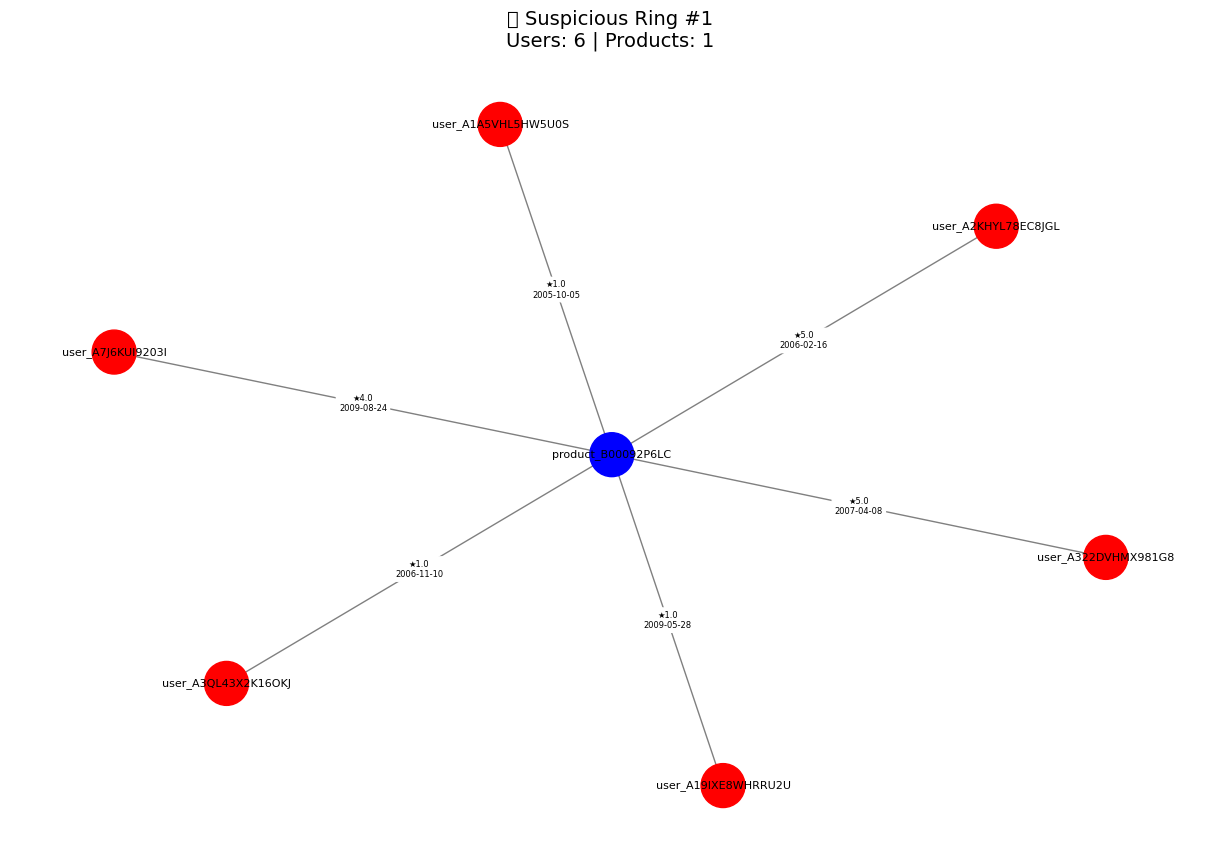

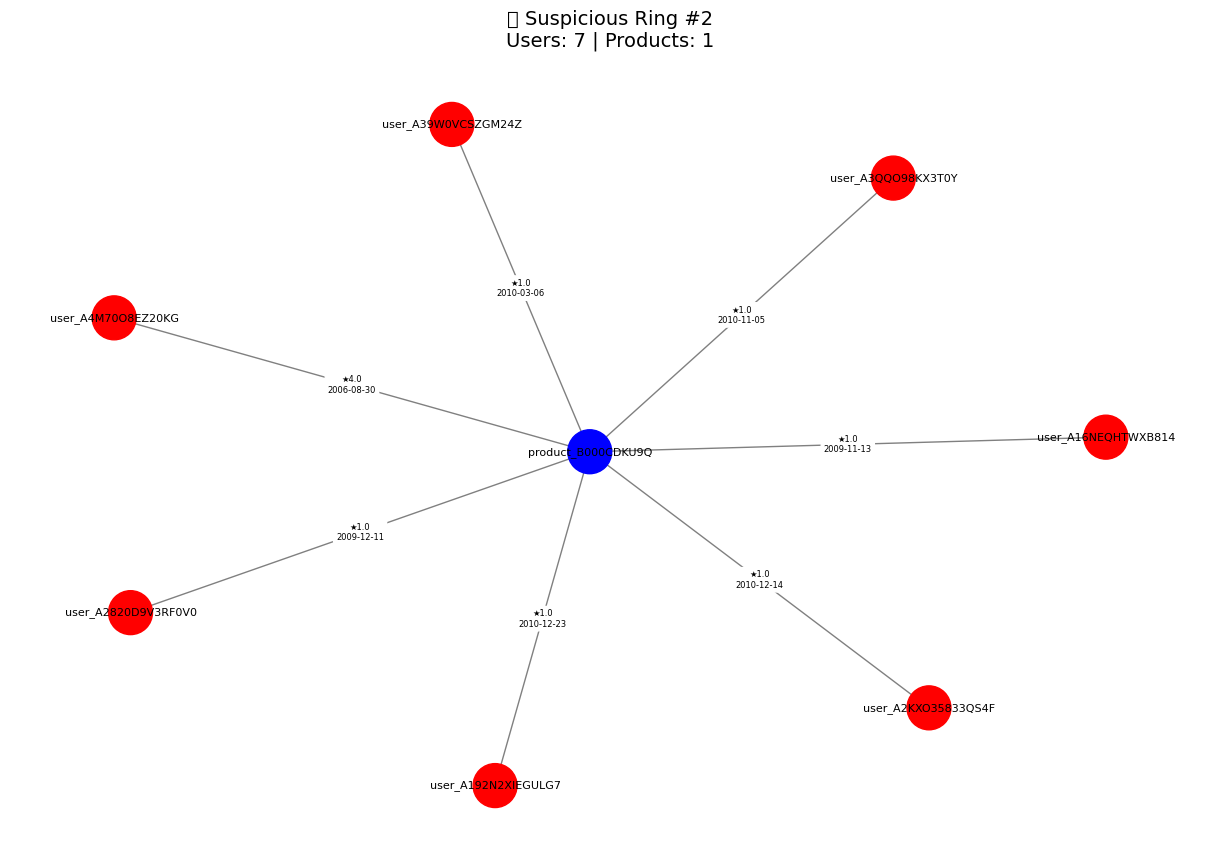

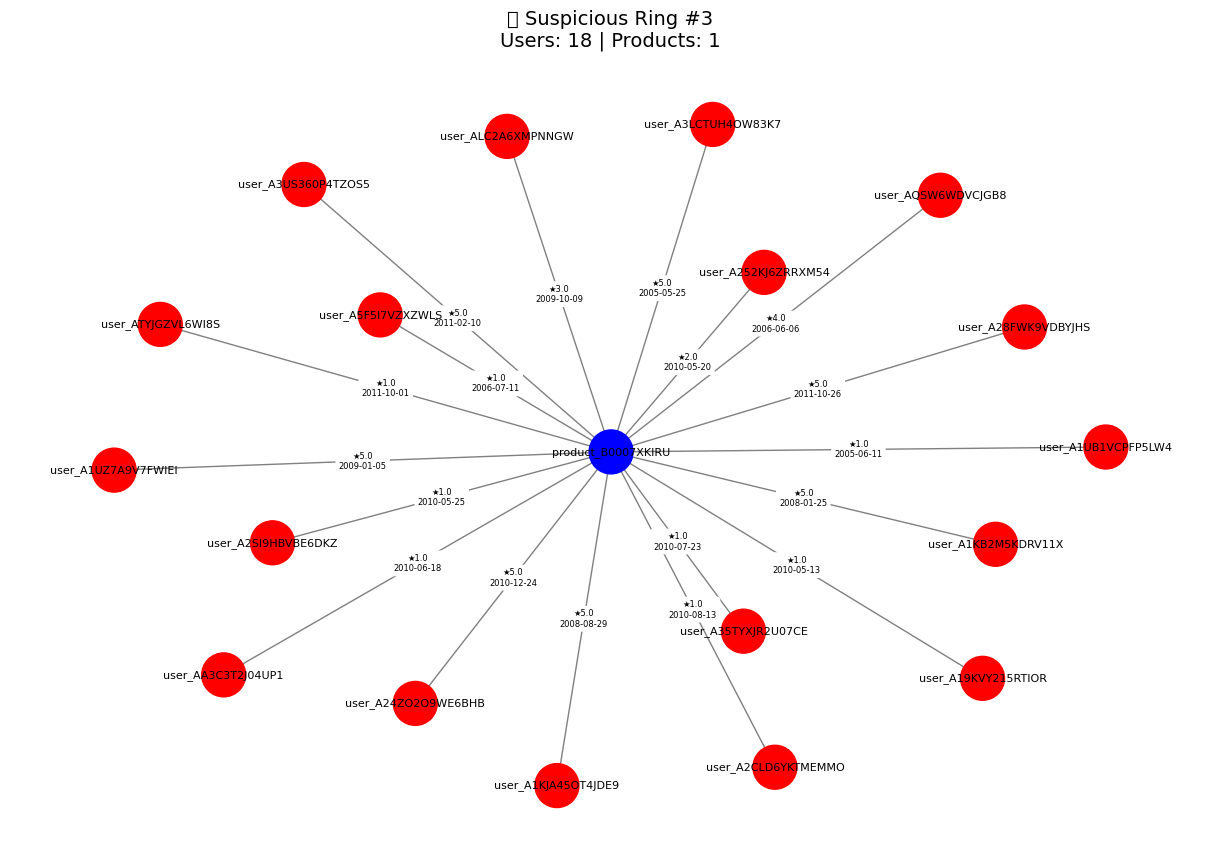

In [46]:
# Load graph if needed
# import pickle
# with open("review_graph.gpickle", "rb") as f:
#     G = pickle.load(f)

for i, ring in enumerate(sorted_rings[:3]):  # Top 3
    visualize_ring(G, ring['users'], ring_id=i+1)


In [30]:
from pyvis.network import Network

def interactive_visualize_ring(G, ring_users, output="top_ring.html"):
    net = Network(height="700px", width="100%", notebook=False, cdn_resources="remote")

    for user in ring_users:
        net.add_node(user, label=f"User: {user}", color="skyblue", shape="dot")
        
        for product in G.neighbors(user):
            if G.nodes[product]['type'] == 'product':
                net.add_node(product, label=f"Product: {product}", color="orange", shape="box")
                net.add_edge(user, product, title="Reviewed")

    try:
        net.show(output)
        print(f"✅ Interactive ring saved to {output}. Open it in your browser.")
    except Exception as e:
        print(f"❌ PyVis rendering failed: {e}")


In [31]:
# Assuming `sorted_rings` contains scored rings (from earlier)
top_ring = sorted_rings[0]

In [32]:
interactive_visualize_ring(G, top_ring['users'], output="top_ring.html")


top_ring.html
❌ PyVis rendering failed: 'NoneType' object has no attribute 'render'


Signal	Why It's Suspicious
- 🔁 Same users review the same products	Coordinated behavior
- ⏱ Reviews are posted within a short time window	Orchestrated timing
- 📝 Review texts are very similar (via embeddings)	Copied or templated
- 🌟 Always high ratings from same group	Bias boost
- 🚫 Reviews are unverified	Possibly fake accounts

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime

def visualize_product_ring(G, product_id, ring_id="N/A"):
    if not G.has_node(product_id):
        print(f"❌ Product node '{product_id}' not found in the graph.")
        return

    if G.nodes[product_id].get('type') != 'product':
        print(f"❌ Node '{product_id}' is not labeled as a product.")
        return

    # Get all users who reviewed this product
    connected_users = [n for n in G.neighbors(product_id) if G.nodes[n]['type'] == 'user']
    
    if not connected_users:
        print(f"⚠️ No users found reviewing product '{product_id}'.")
        return

    # Get all other products reviewed by these users (to show possible collusion)
    colluded_products = set()
    for user in connected_users:
        colluded_products.update(n for n in G.neighbors(user) if G.nodes[n]['type'] == 'product')
    
    # Create subgraph of users + all their reviewed products
    nodes_to_include = set(connected_users) | colluded_products
    subgraph = G.subgraph(nodes_to_include)

    # Assign node colors
    color_map = []
    for node in subgraph.nodes():
        if node == product_id:
            color_map.append('gold')   # The target product
        elif node in connected_users:
            color_map.append('red')    # Suspicious users
        else:
            color_map.append('blue')   # Other products

    # Edge labels: rating + timestamp
    edge_labels = {}
    for u, v in subgraph.edges():
        data = G.get_edge_data(u, v)
        rating = data.get('rating', 'N/A')
        ts = data.get('timestamp')
        try:
            time_str = datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d') if ts else "N/A"
        except:
            time_str = "Invalid"
        edge_labels[(u, v)] = f"★{rating}\n{time_str}"

    # Draw the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subgraph, seed=42)

    nx.draw(subgraph, pos, with_labels=True, node_color=color_map,
            node_size=1000, font_size=8, edge_color='gray', linewidths=1)

    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels,
                                 font_size=6, label_pos=0.5, rotate=False)

    plt.title(f"🕵️ Suspicious Activity Around Product: {product_id}\nUsers: {len(connected_users)} | Related Products: {len(colluded_products)}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


/var/folders/16/xfx_gvv952jdprrpdvgfy79h0000gn/T/ipykernel_34935/136329603.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/hiteshgupta/Documents/TrustsphereAI/trustAI/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128373 (\N{SLEUTH OR SPY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


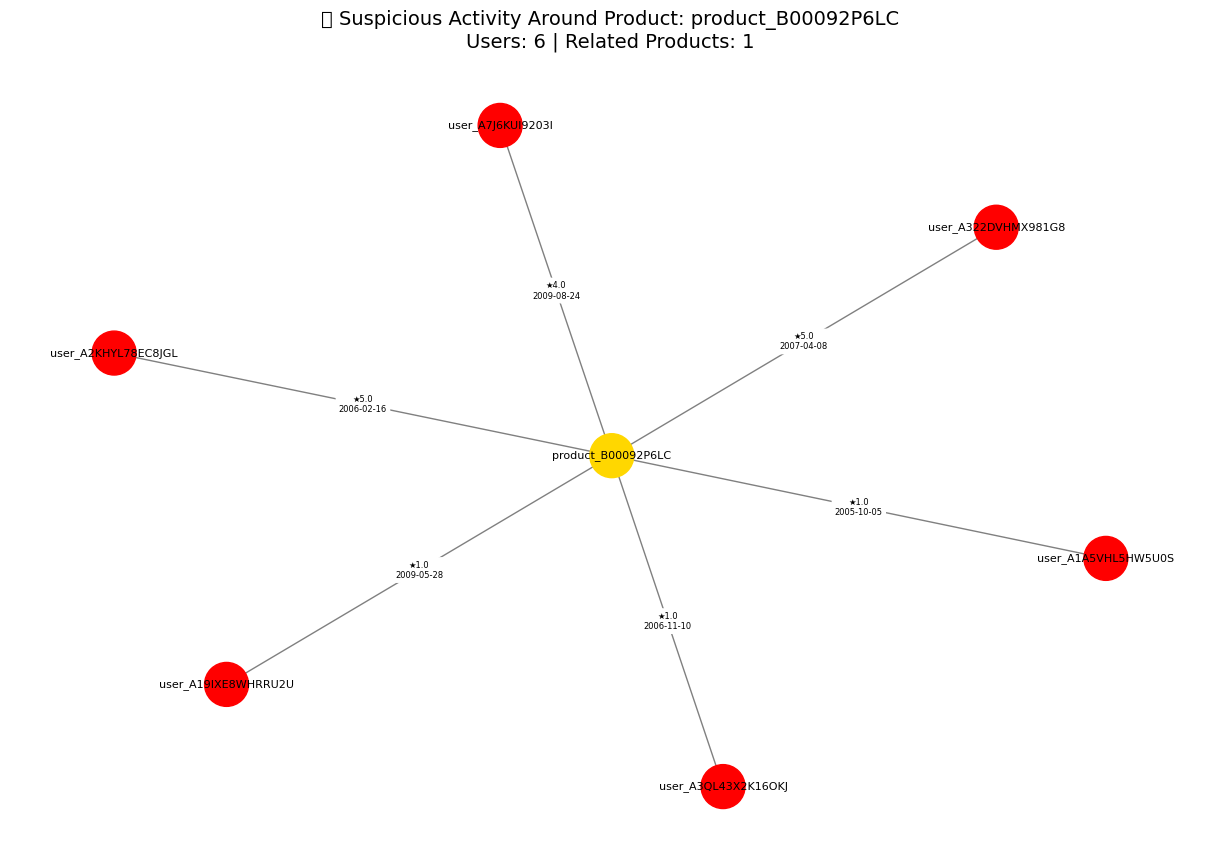

In [11]:
# Pass the product ID node as it appears in your graph
visualize_product_ring(G, "product_B00092P6LC")
